In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import fits
import pandas as pd
import sys
sys.path.append("/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/HST/AllHSTCode/")
from Small_Pix_Filter_TVM import SDSS_pixel_filter
#Use the package that Amy used for determining weights
from lmfit import minimize, Parameters

---

In [2]:
#ica_path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/"
ica_path = "/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/"

#Load in ICA components and save in Dataframe
cmod = pd.read_csv(ica_path+"amy_12603000_10c_180421.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
clow = pd.read_csv(ica_path+"amy_12753000_lowew_10c_181101_v1.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
chigh = pd.read_csv(ica_path+"amy_12653000_hew_hsn_7c_190302.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7"])
#Load in wave arrays for each set of components
wave_mod = pd.read_csv(ica_path+"wav_12603000.dat", names=["wave"]).values.flatten()
wave_low = pd.read_csv(ica_path+"wav_12753000.dat", names=["wave"]).values.flatten()
wave_high= pd.read_csv(ica_path+"wav_12653000.dat", names=["wave"]).values.flatten()

In [3]:
components_mod  = np.array([cmod.iloc[:,i].values for i in range(cmod.shape[1])])
components_low  = np.array([clow.iloc[:,i].values for i in range(clow.shape[1])])
components_high = np.array([chigh.iloc[:,i].values for i in range(chigh.shape[1])])

In [4]:
def masking(wave, flux, fluxerr):
    mask_fit = np.zeros(len(flux))
    median_flux = SDSS_pixel_filter(wave, flux)
    median_err  = SDSS_pixel_filter(wave, fluxerr)
    #em = emission_lines(wave/(1+z))
    for j in range(len(median_flux)):
        if ( (abs(flux[j]-median_flux[j]) > 4*abs(median_err[j])) ):#  and ~em[j] ): #change condition as needed
            mask_fit[j] = 1
    return (mask_fit==1)
    

def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data

def ICA_fit(components, wave, spectrum, ivar, flags):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
    #MASK = mask(components, wave, spectrum, ivar, flags)
    #print(components.shape, spectrum.shape)
    
    badpix = masking(wave, spectrum, 1/np.sqrt(ivar))
    ivar[badpix] = 0
    
    return minimize(residual, params, args=(components, spectrum, ivar), method="lbfgsb", nan_policy='omit')

In [5]:
def do_ICA(wave, flux, errs, mask, name):
    
    #Apply mask and get fits
    mod_mask  = (wave>1260)&(wave<3000)
    low_mask  = (wave>1275)&(wave<3000)
    high_mask = (wave>1265)&(wave<3000)
    
    mod_comp_mask = (wave_mod>min(wave[mod_mask]))&(wave_mod<max(wave[mod_mask]))
    low_comp_mask = (wave_low>min(wave[low_mask]))&(wave_low<max(wave[low_mask]))
    high_comp_mask = (wave_high>min(wave[high_mask]))&(wave_high<max(wave[high_mask]))
    
    #print(mod_comp_mask.shape)
    ###########
    #Adjust array sizes
    wave_mod_fit = wave_mod[mod_comp_mask]
    components_mod_fit = components_mod[:,mod_comp_mask] 
    wave_low_fit = wave_low[low_comp_mask]
    components_low_fit = components_low[:,low_comp_mask] 
    wave_high_fit = wave_high[high_comp_mask]
    components_high_fit = components_high[:,high_comp_mask]
    
    ###############
    #Now do fitting
        
    # mod EW
    #print(len(wave[mod_mask]), len(wave_mod_fit))
    if len(wave[mod_mask])==len(wave_mod_fit):
        fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[mod_mask])-len(wave_mod_fit) == -1:
            fit_mod  = ICA_fit(components_mod_fit[:,:-1], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
        elif len(wave[mod_mask])-len(wave_mod_fit) == 1:
            fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
    #low EW
    if len(wave[low_mask])==len(wave_low_fit):
        fit_low  = ICA_fit(components_low_fit, wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[low_mask])-len(wave_low_fit) == -1:
            fit_low  = ICA_fit(components_low_fit[:,:-1], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
        elif len(wave[low_mask])-len(wave_low_fit) == 1:
            fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])

    #high EW
    if len(wave[high_mask])==len(wave_high_fit):
        fit_high  = ICA_fit(components_high_fit, wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[high_mask])-len(wave_high_fit) == -1:
            fit_high  = ICA_fit(components_high_fit[:,:-1], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
        elif len(wave[high_mask])-len(wave_high_fit) == 1:
            #print(wave_high_fit.shape, wave[high_mask].shape)
            fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])
        
    #fit_mod   = ICA_fit(components_mod[:,mod_comp_mask], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask]) if len(wave[mod_mask])==len(wave_mod) else ICA_fit(components_mod[:,:-1], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
    #fit_low   = ICA_fit(components_low[:,mod_comp_mask], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask]) if len(wave[low_mask])==len(wave_low) else ICA_fit(components_low[:,:-1], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
    #fit_high  = ICA_fit(components_high[:,mod_comp_mask], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask]) if len(wave[high_mask])==len(wave_high) else ICA_fit(components_high[:,:-1], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
    
    #compute weights
    weights_mod  = [fit_mod.params[i].value for i in fit_mod.params]
    weights_low  = [fit_low.params[i].value for i in fit_low.params]
    weights_high = [fit_high.params[i].value for i in fit_high.params]
    
    #And plot
    fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(17,20))

    ax1.plot(wave, flux)
    ax1.plot(wave_low, np.dot(weights_low, components_low), lw=3.5)
    ax1.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_low, components_low)))
    ax1.set_xscale("log")
    ax1.set_title("Moderate EW")

    ax2.plot(wave, flux)
    ax2.plot(wave_mod, np.dot(weights_mod, components_mod), lw=3.5)
    ax2.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_mod, components_mod)))
    ax2.set_xscale("log")
    ax2.set_title("Low EW")

    ax3.plot(wave, flux)
    ax3.plot(wave_high, np.dot(weights_high, components_high), lw=3.5)
    ax3.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_high, components_high)))
    ax3.set_xscale("log")
    ax3.set_title("High EW")

    plt.suptitle(name)
    plt.show()

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


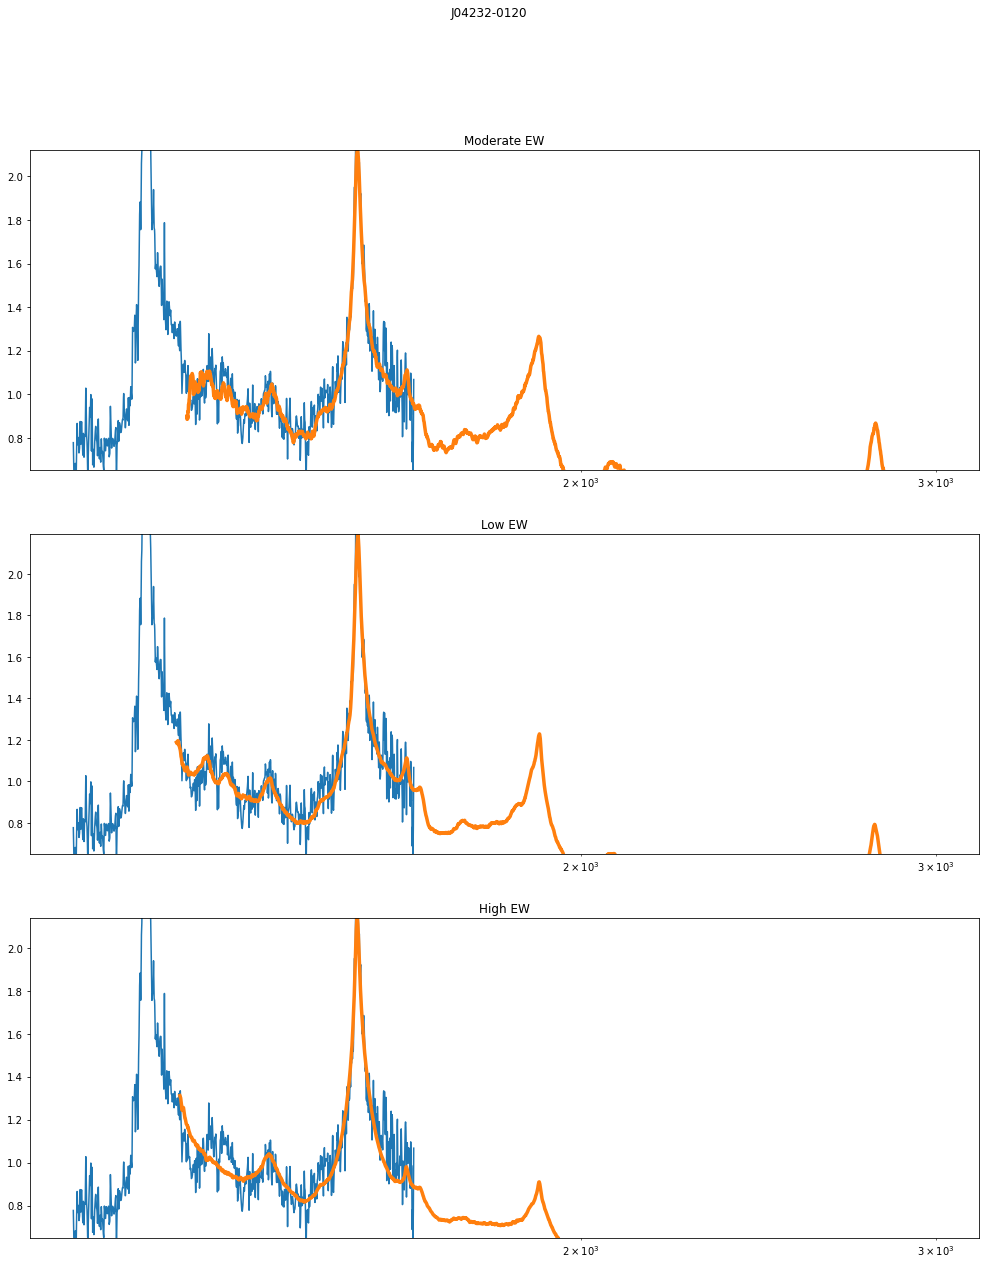

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


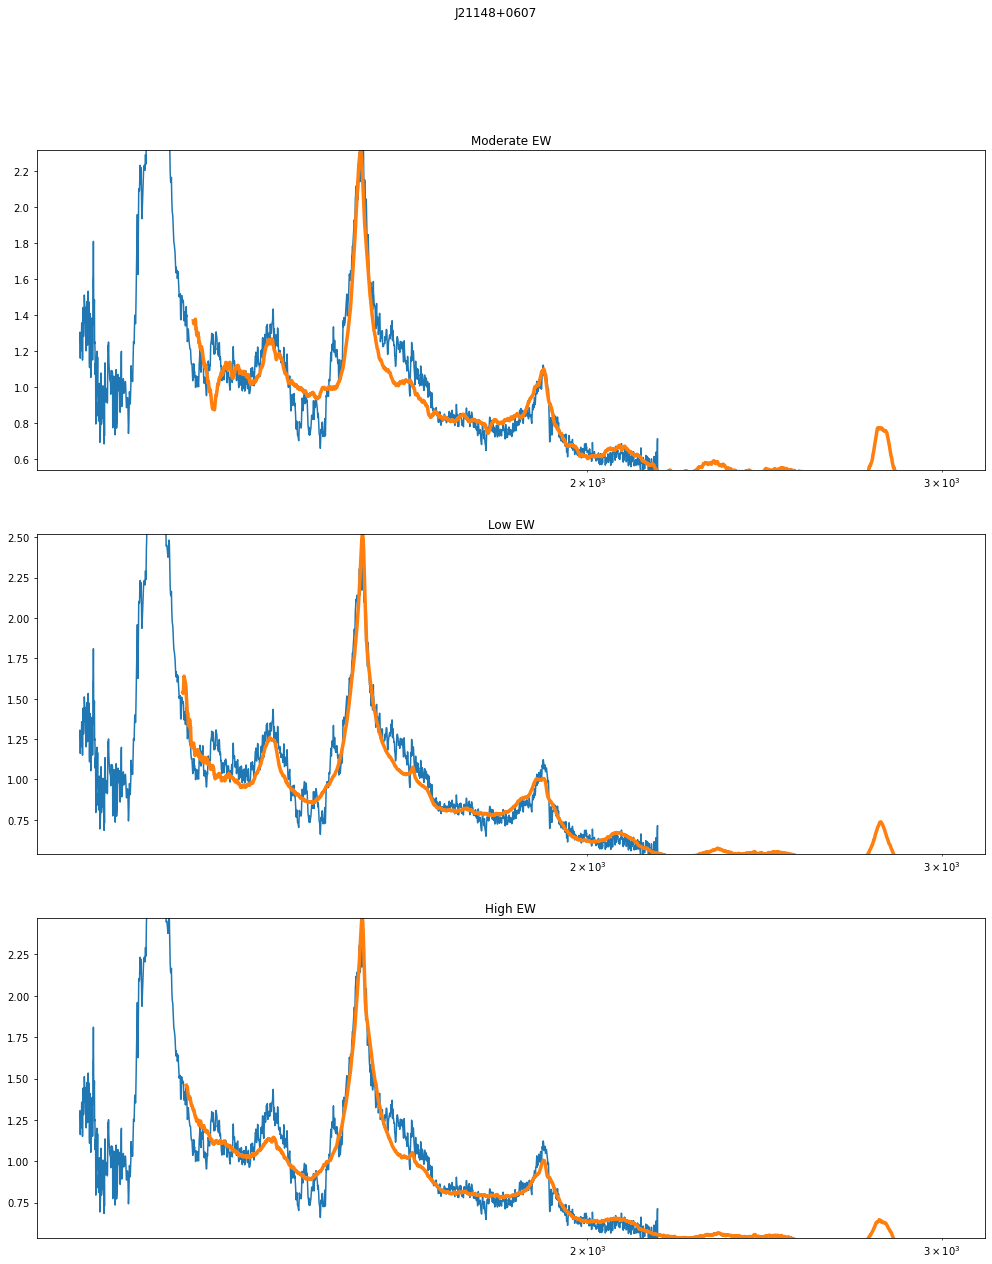

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


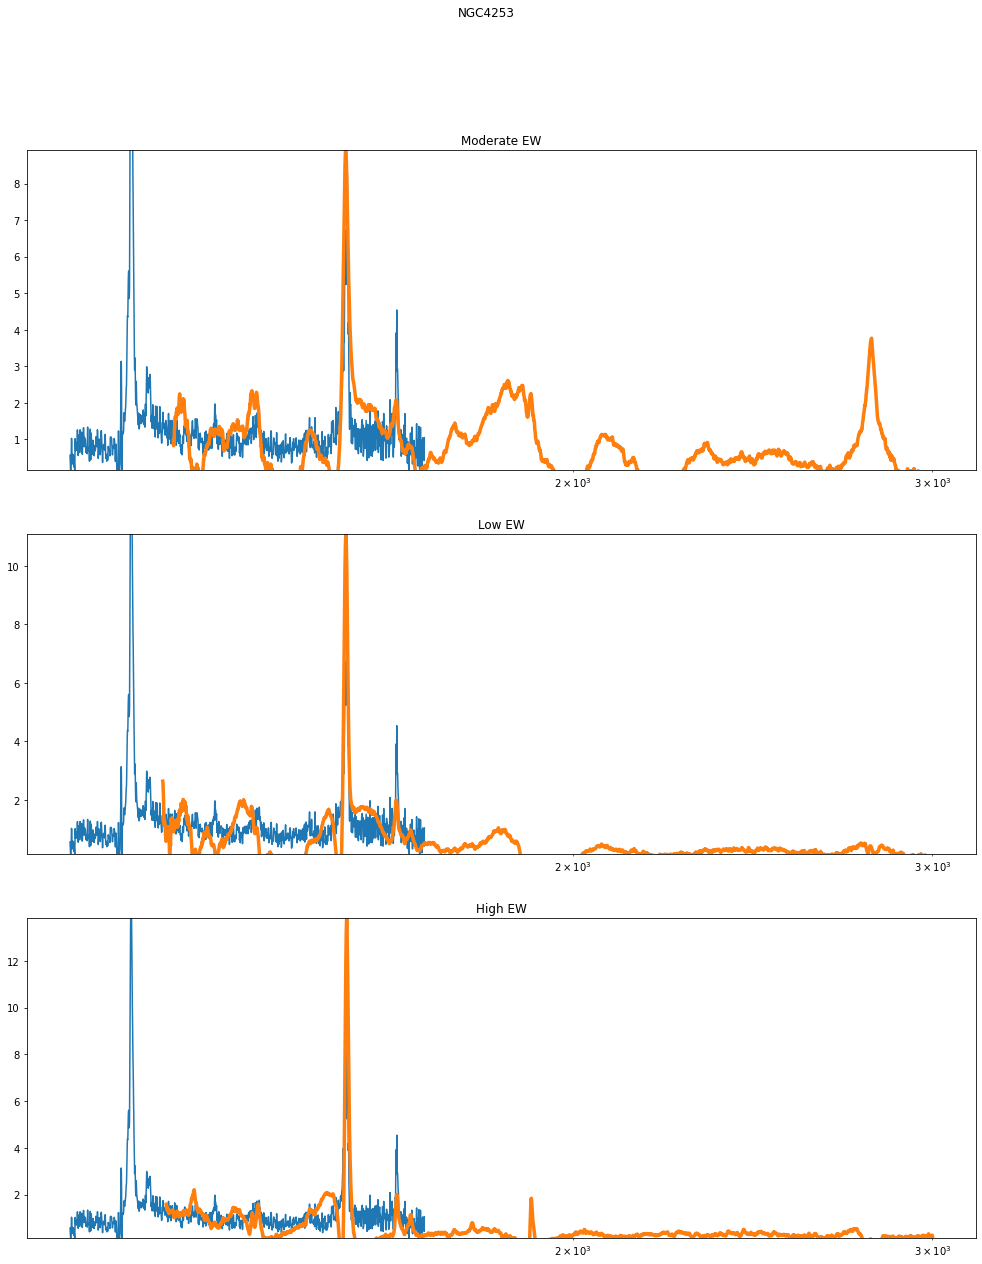

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


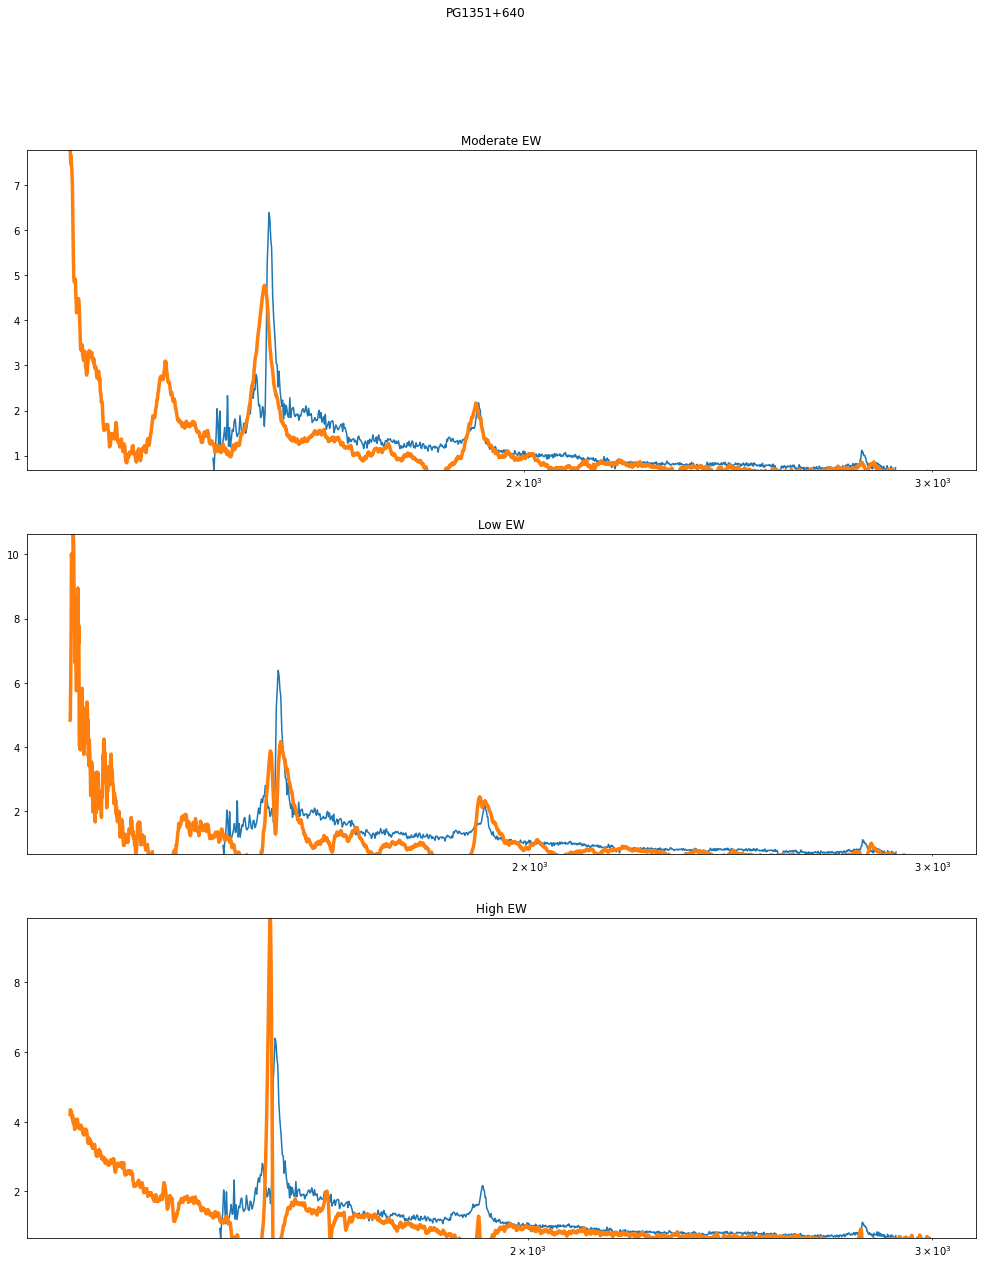

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


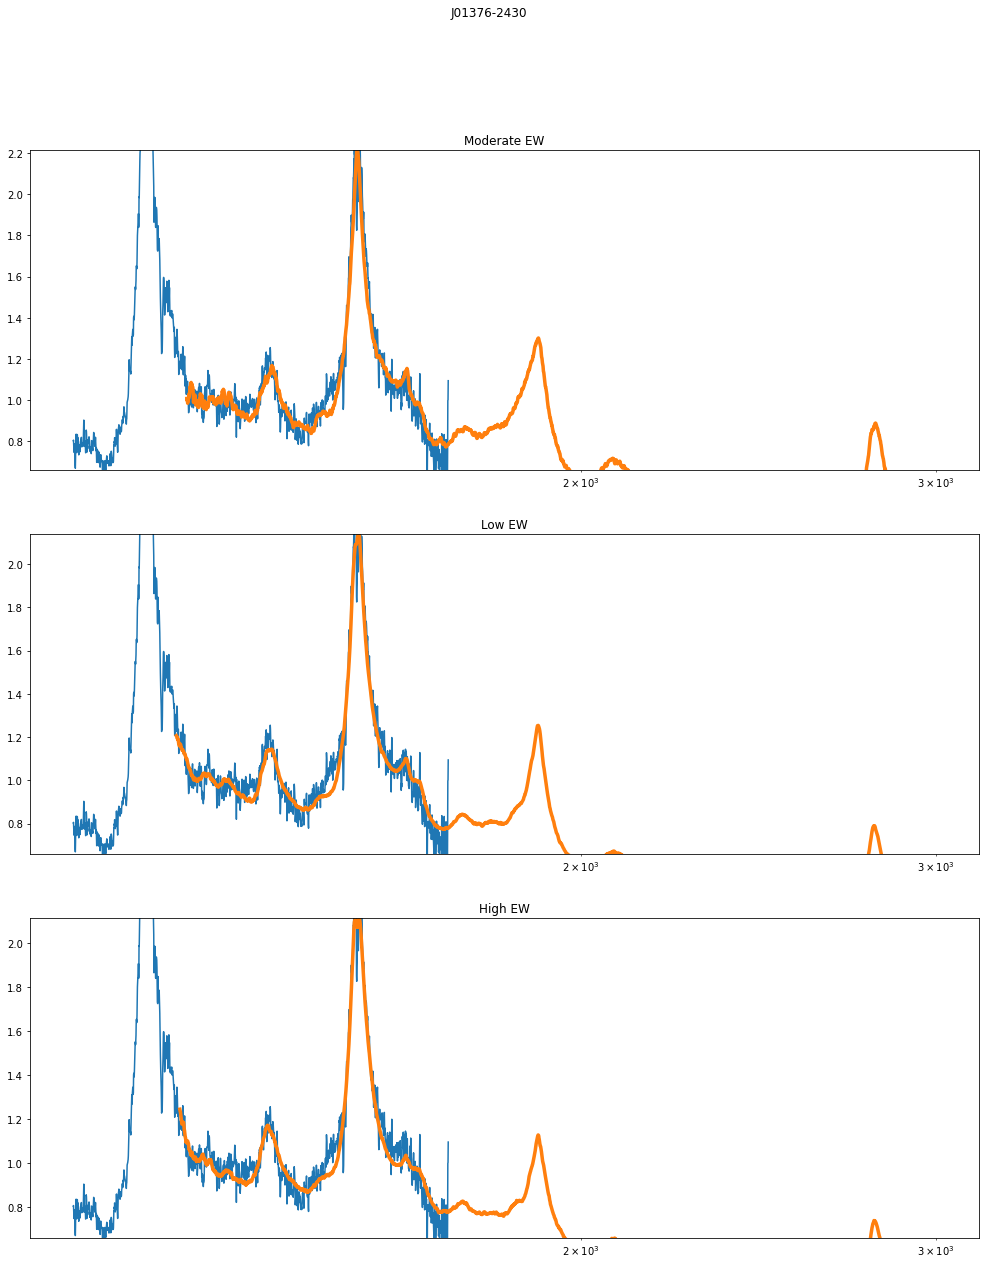

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


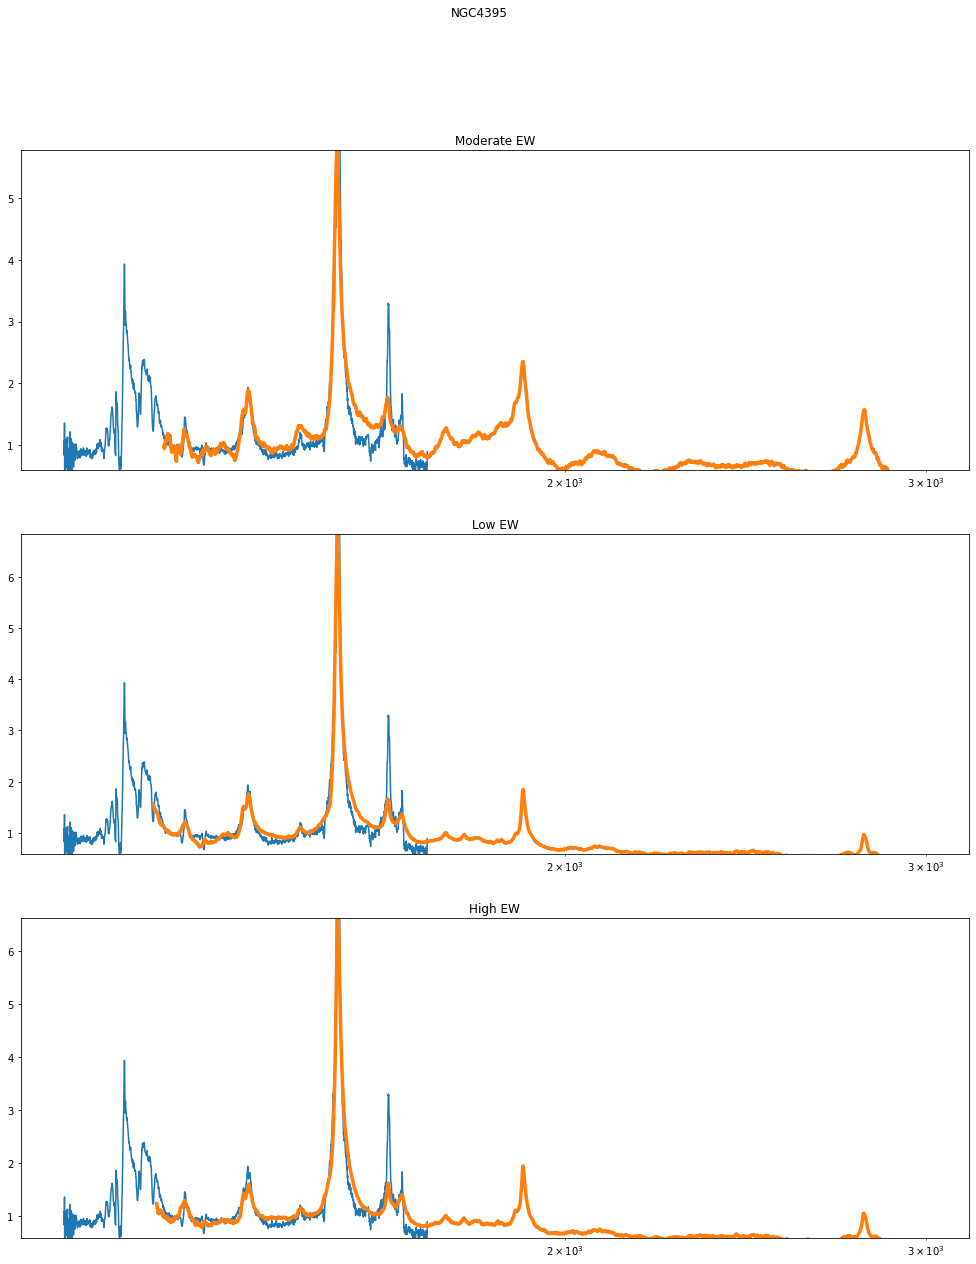

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


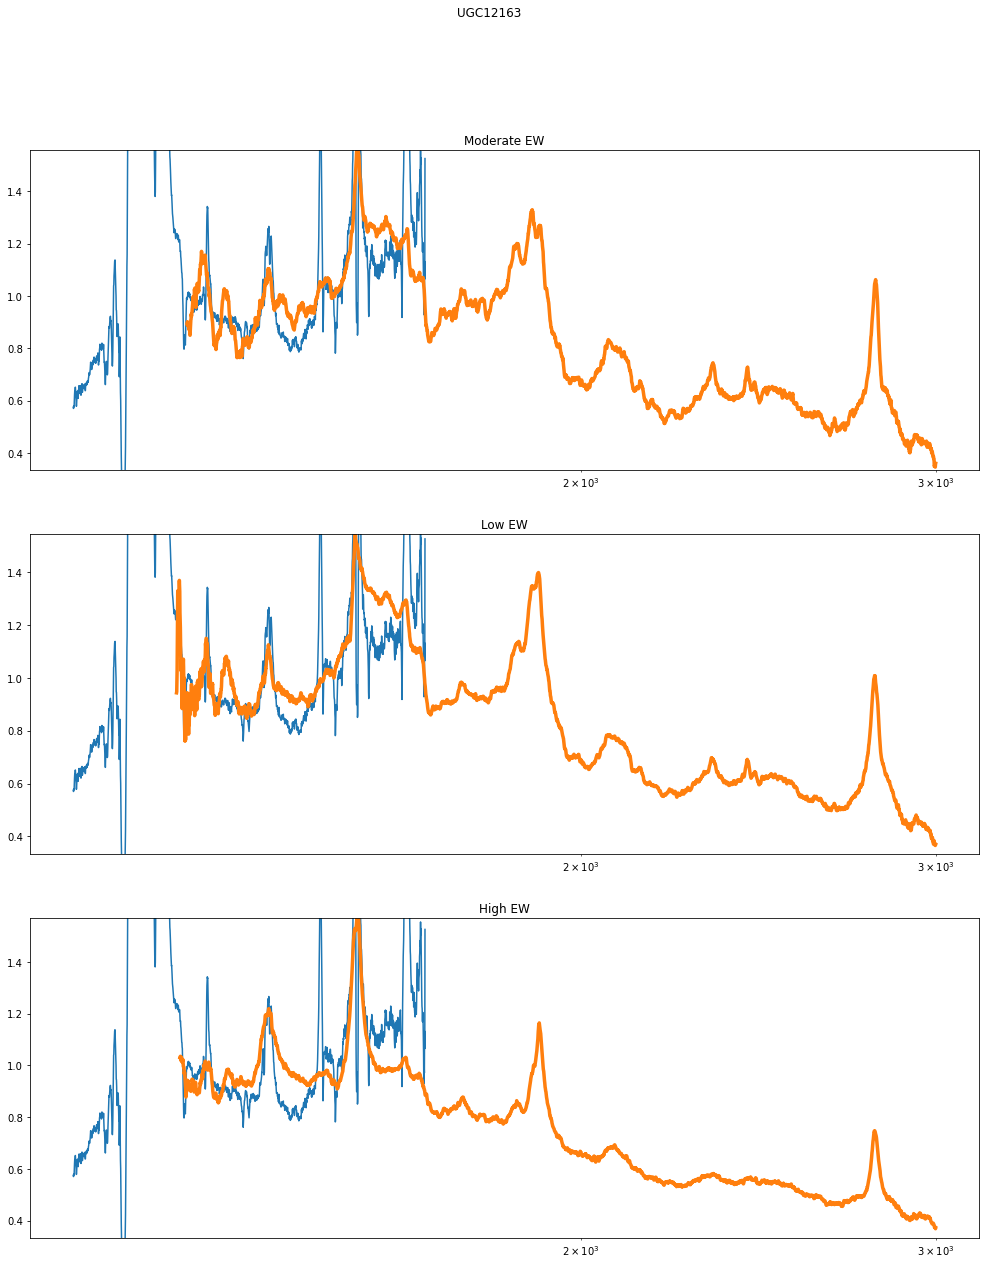

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


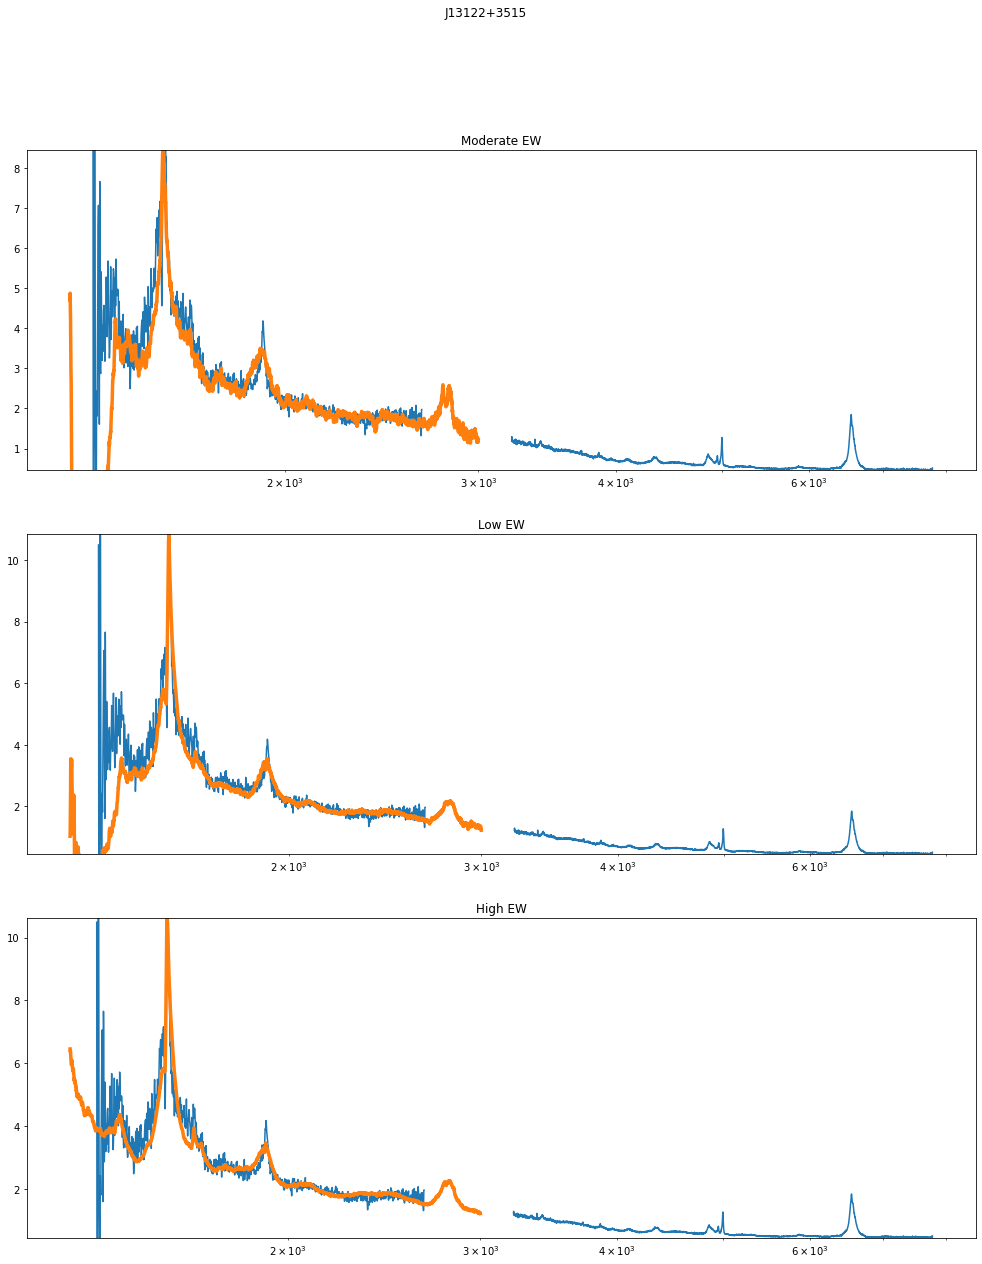

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


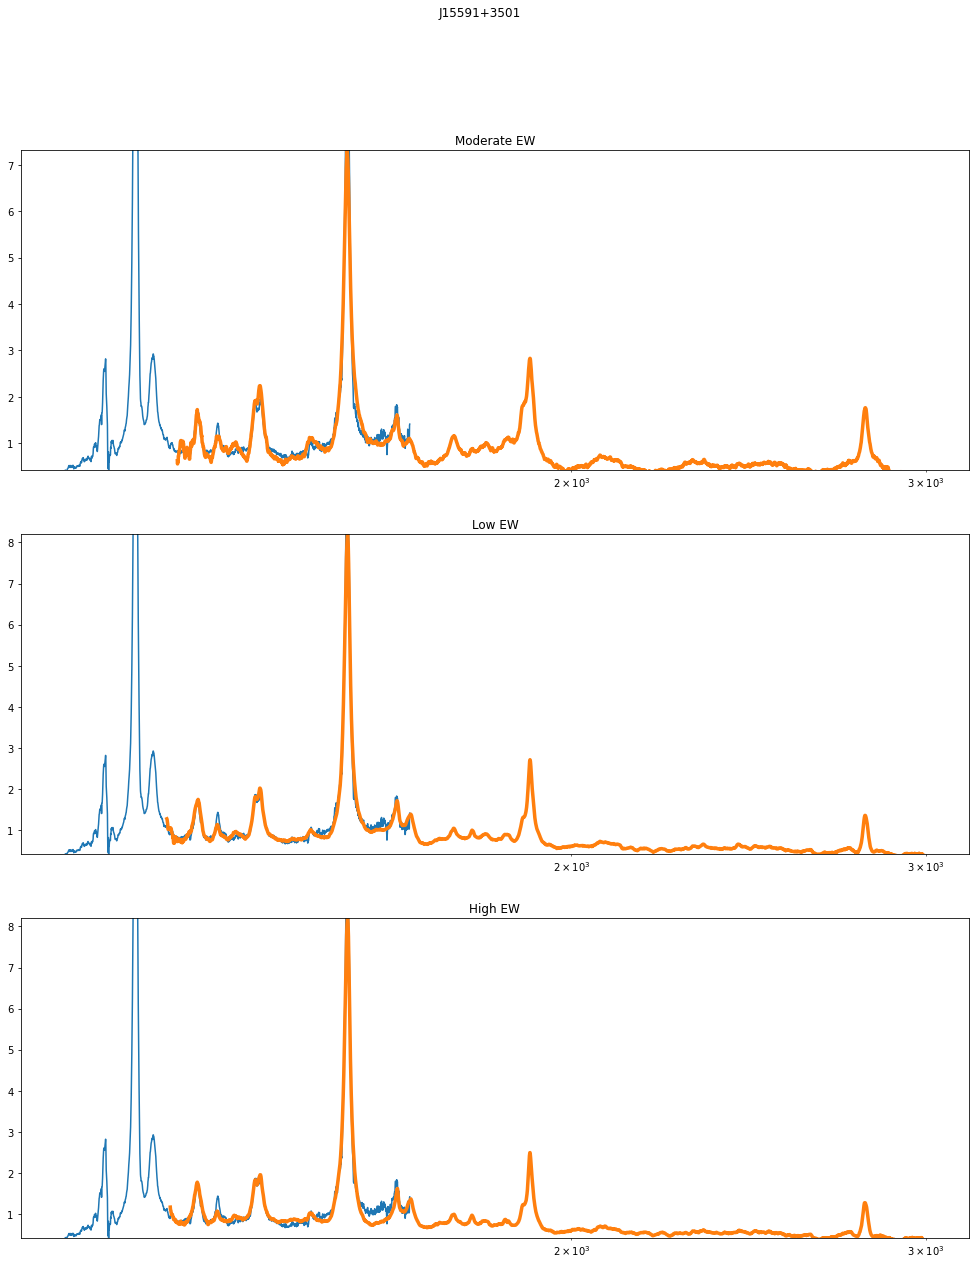

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


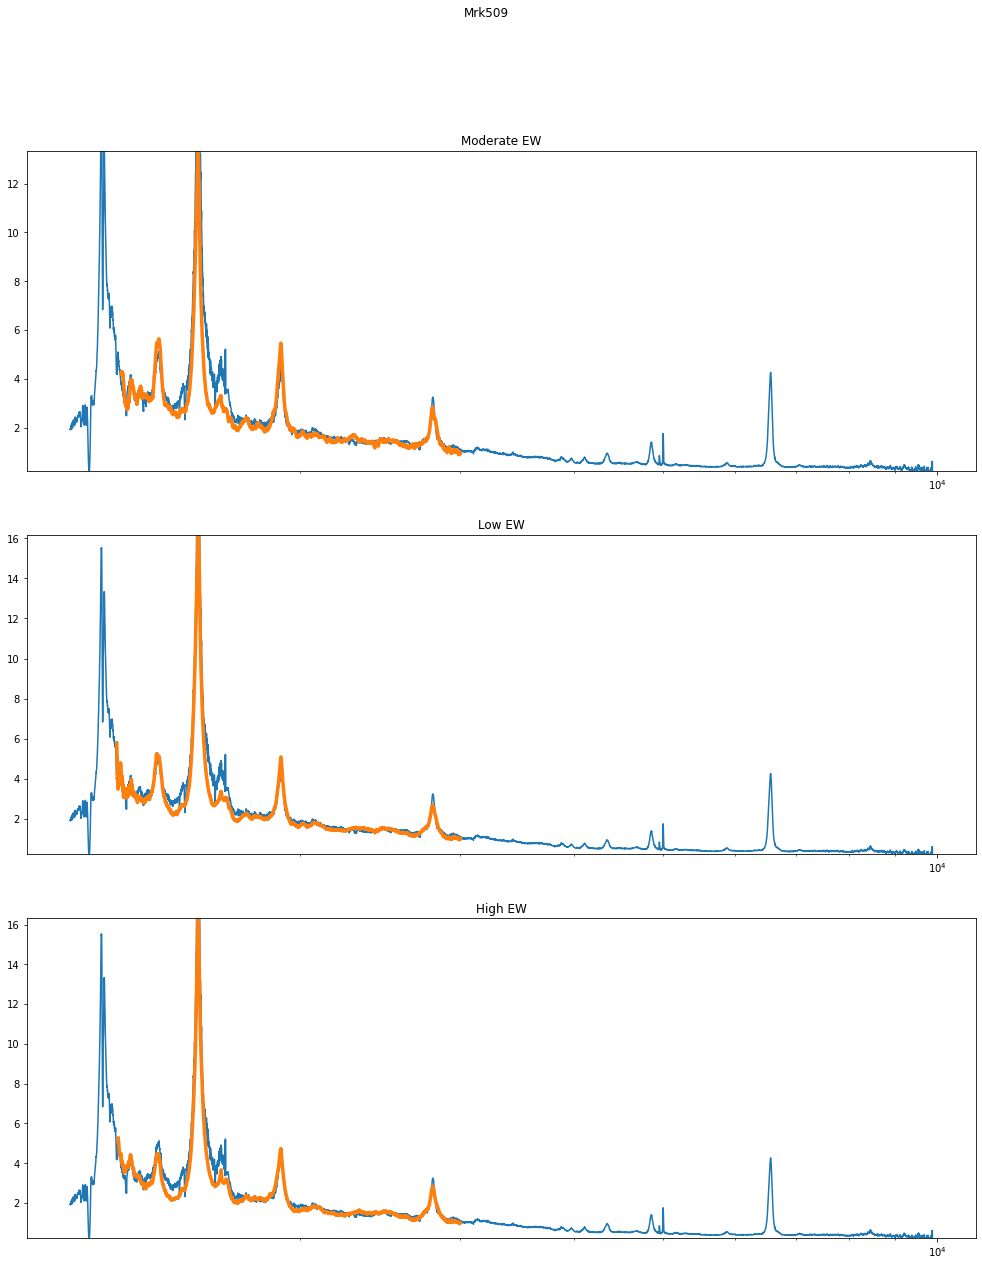

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


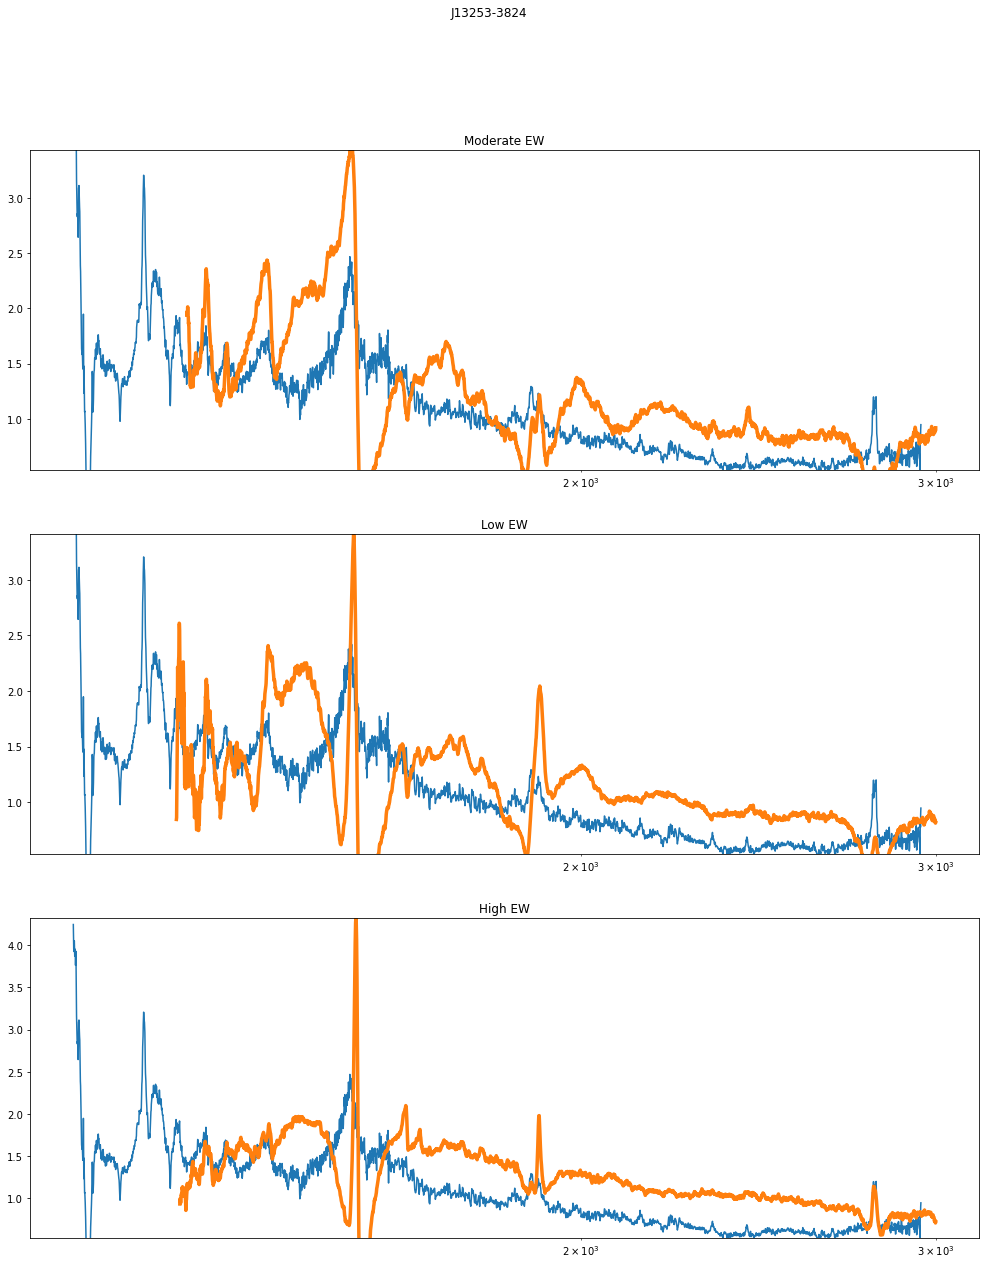

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


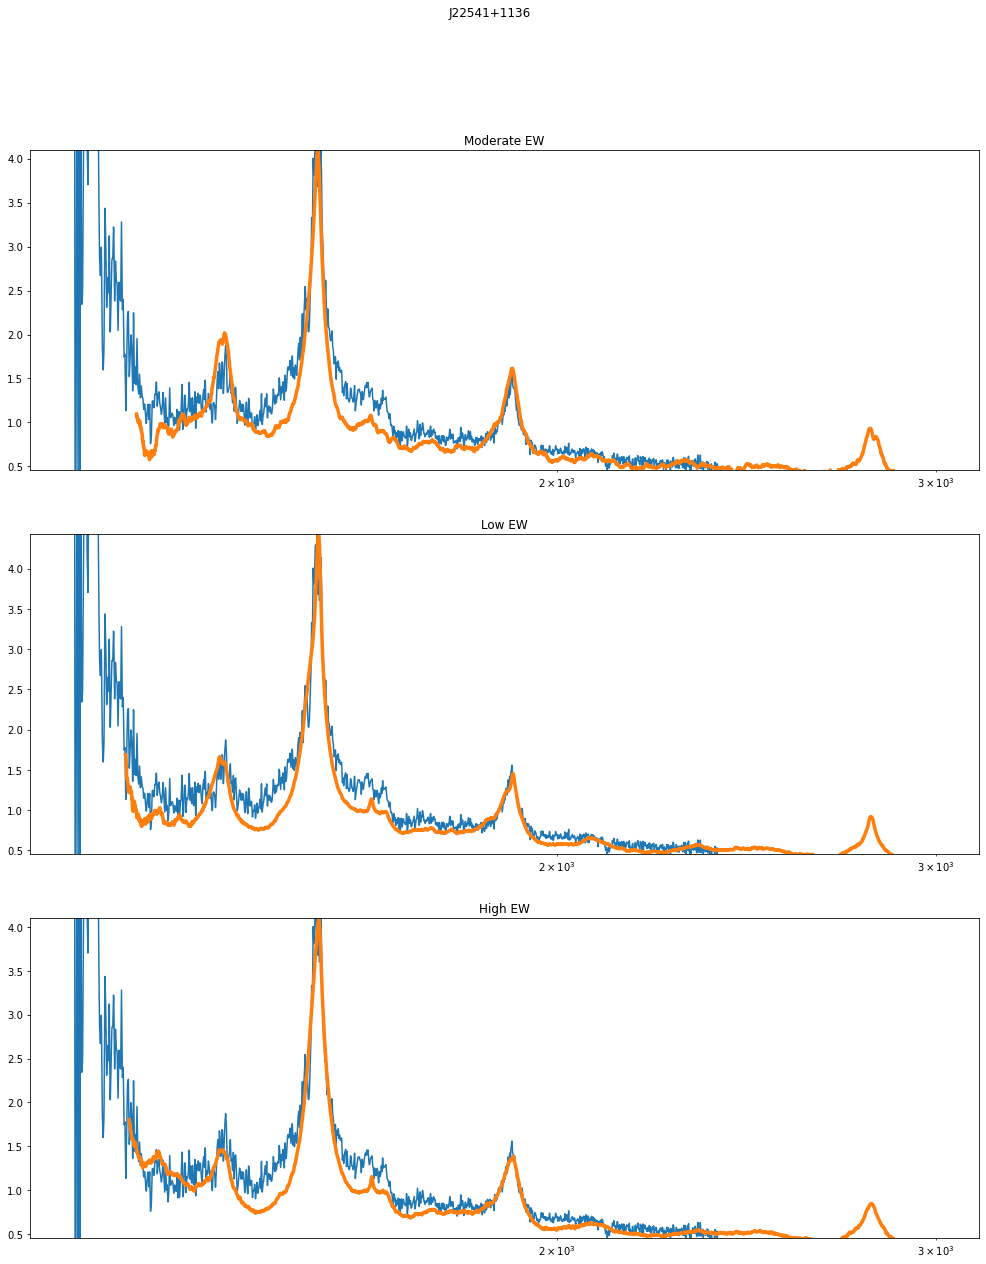

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


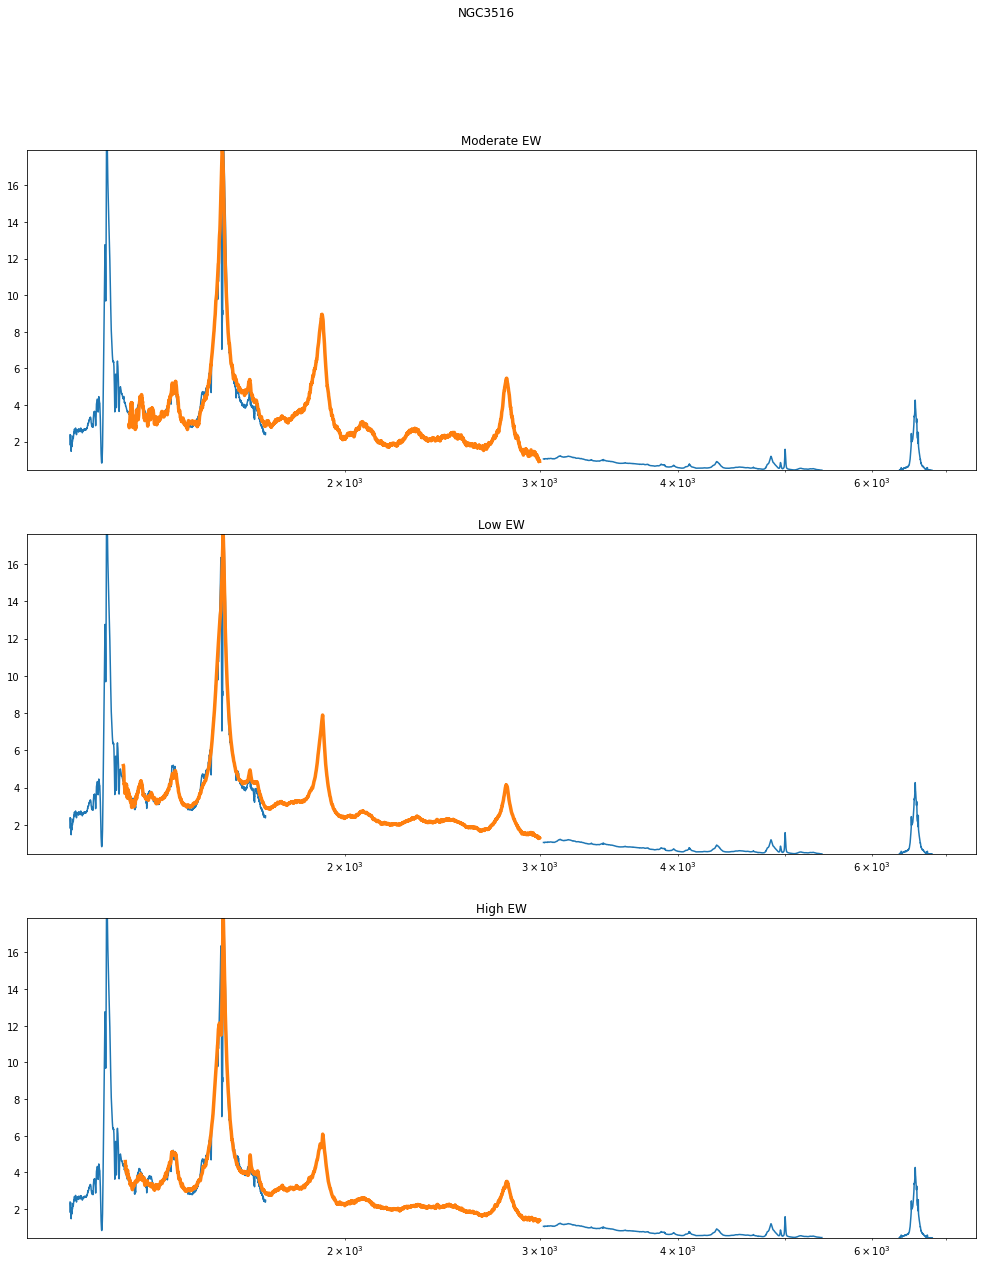

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


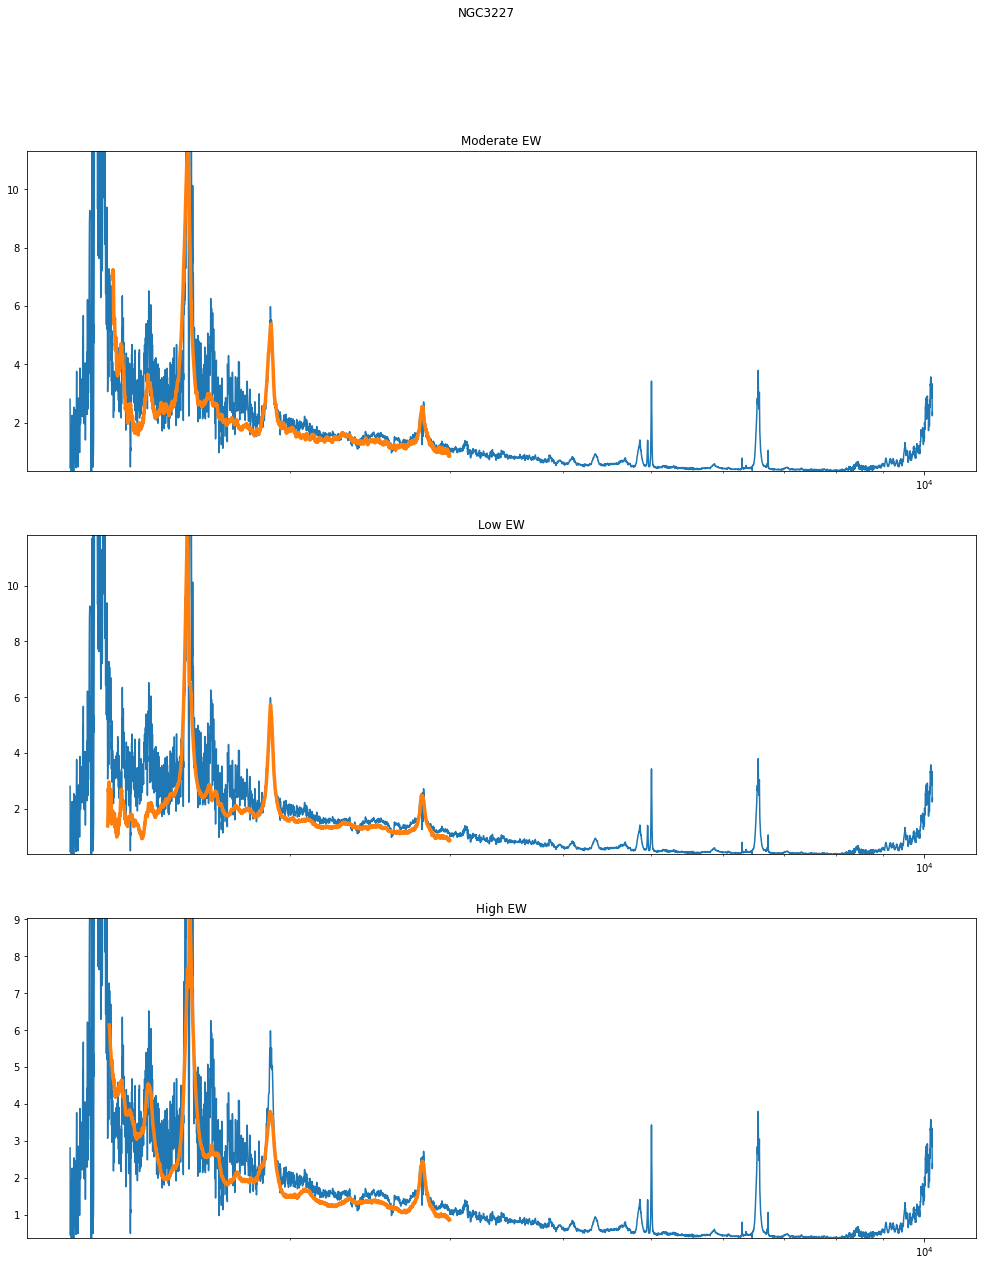

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


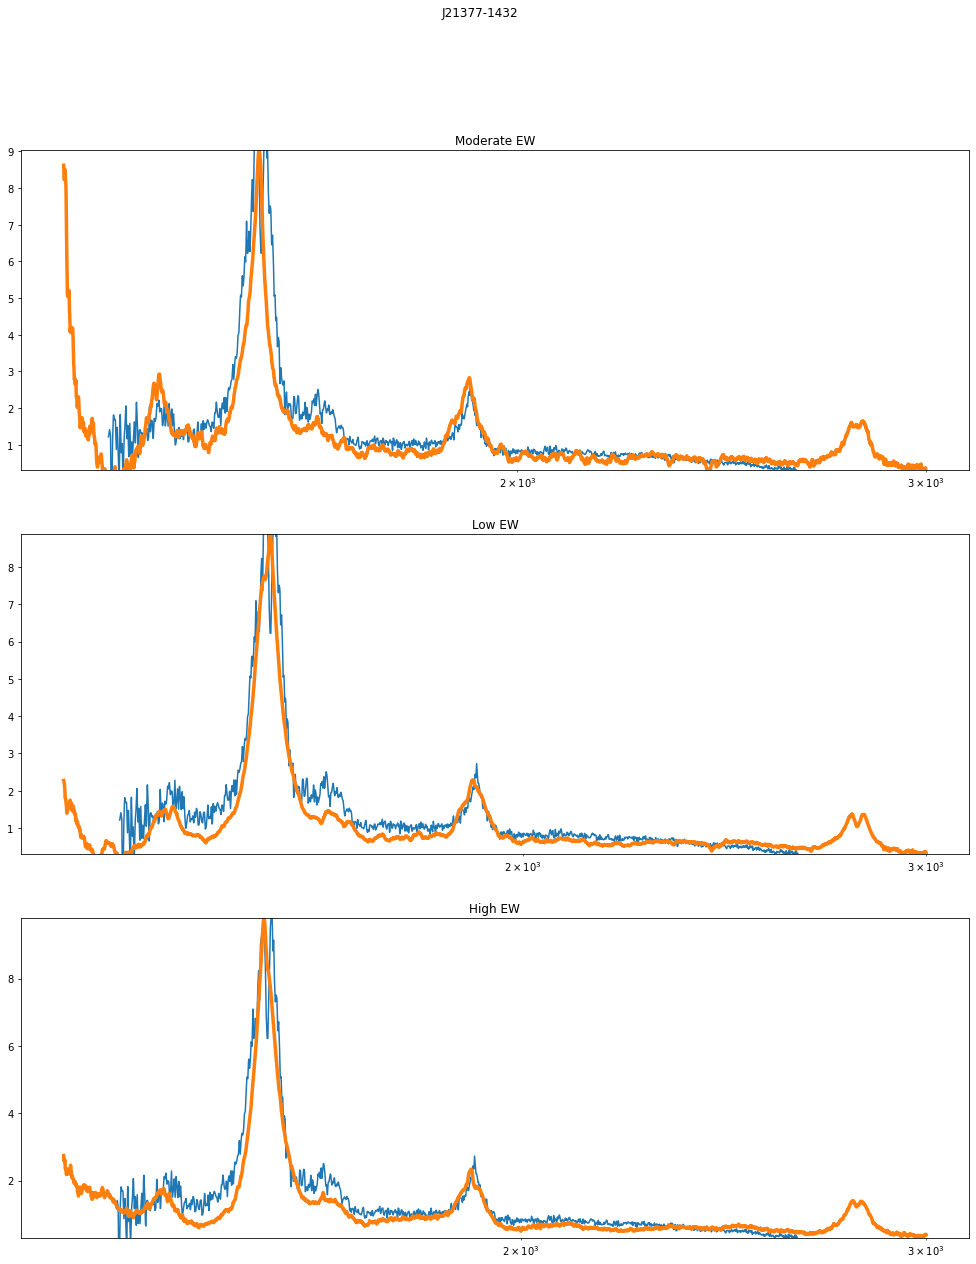

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


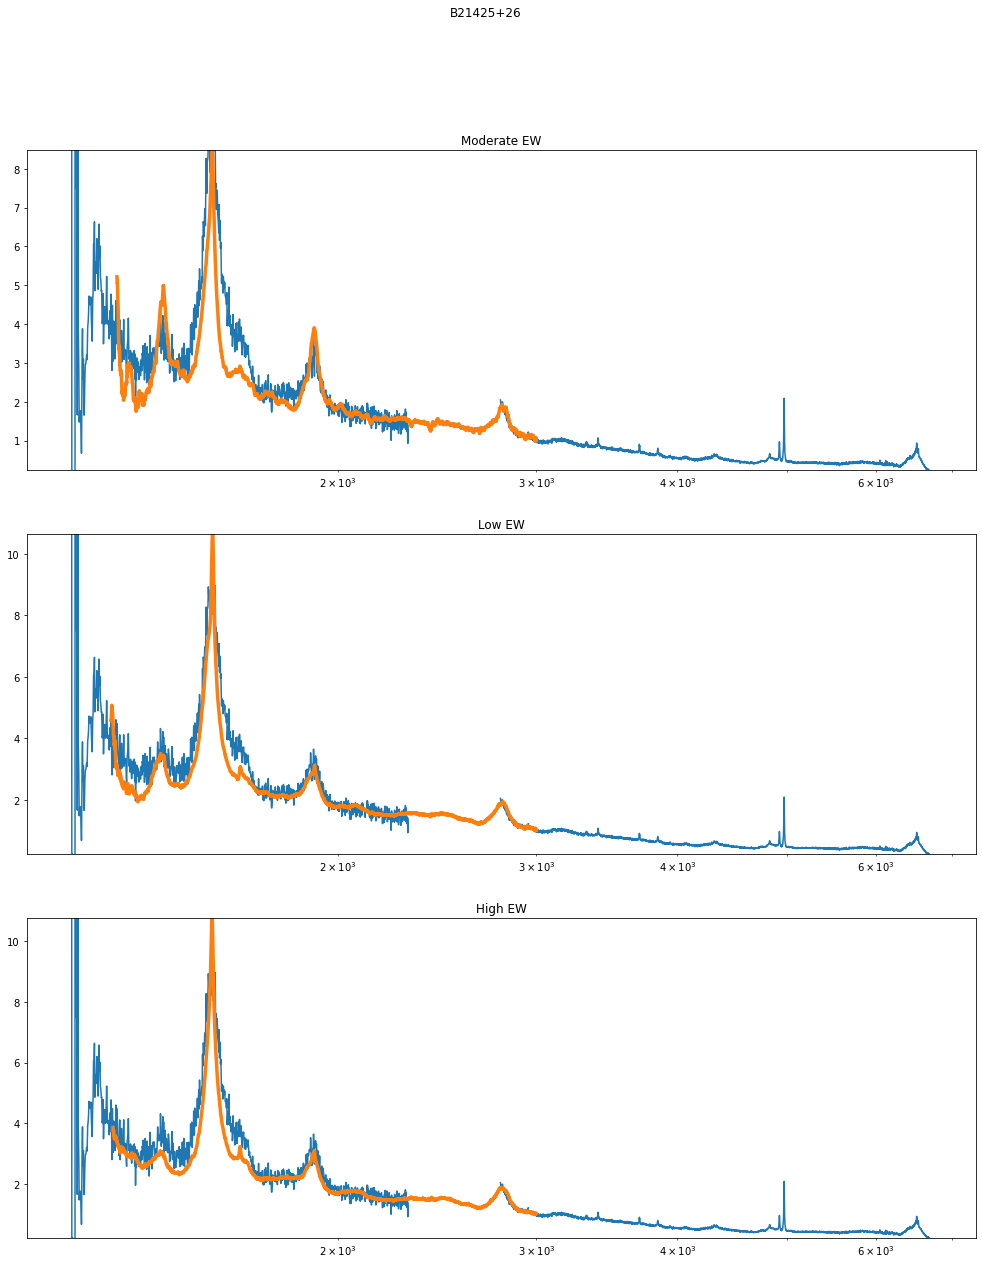

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


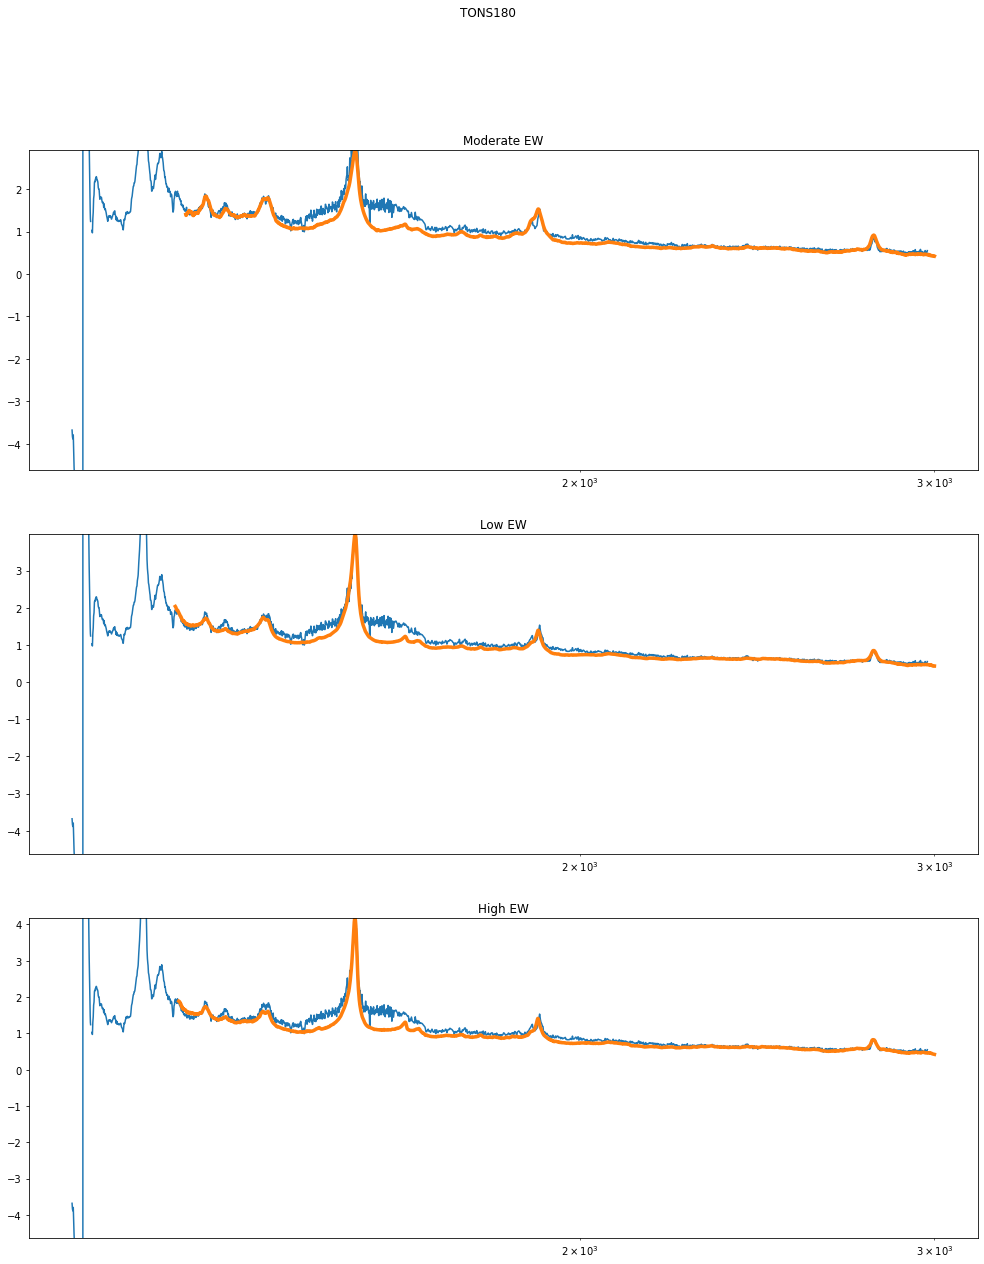

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


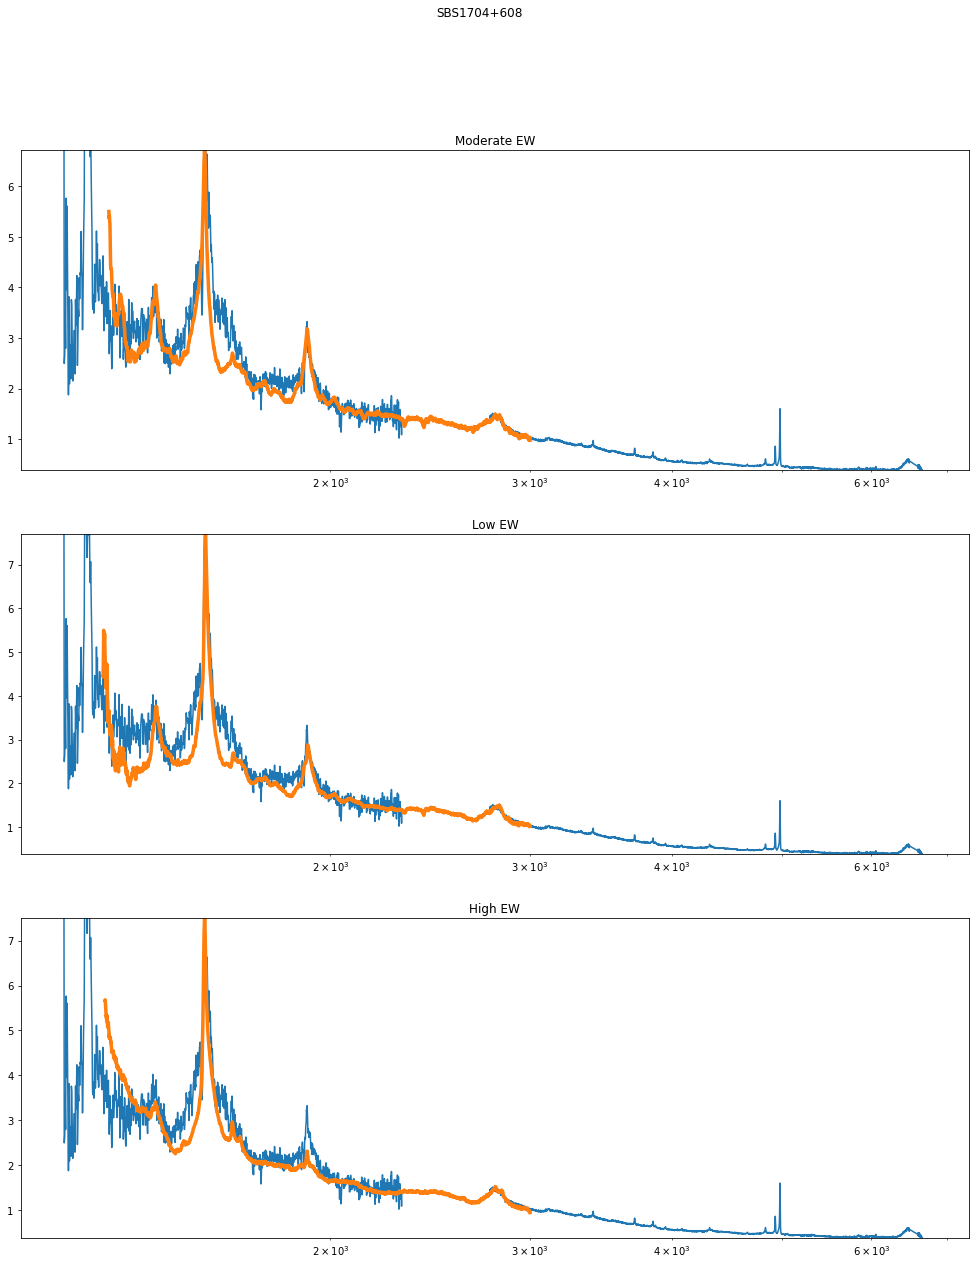

<ipython-input-5-a5faad8d6ddf>:34: RuntimeWarning: divide by zero encountered in true_divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:43: RuntimeWarning: divide by zero encountered in true_divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])
<ipython-input-5-a5faad8d6ddf>:54: RuntimeWarning: divide by zero encountered in true_divide
  fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])


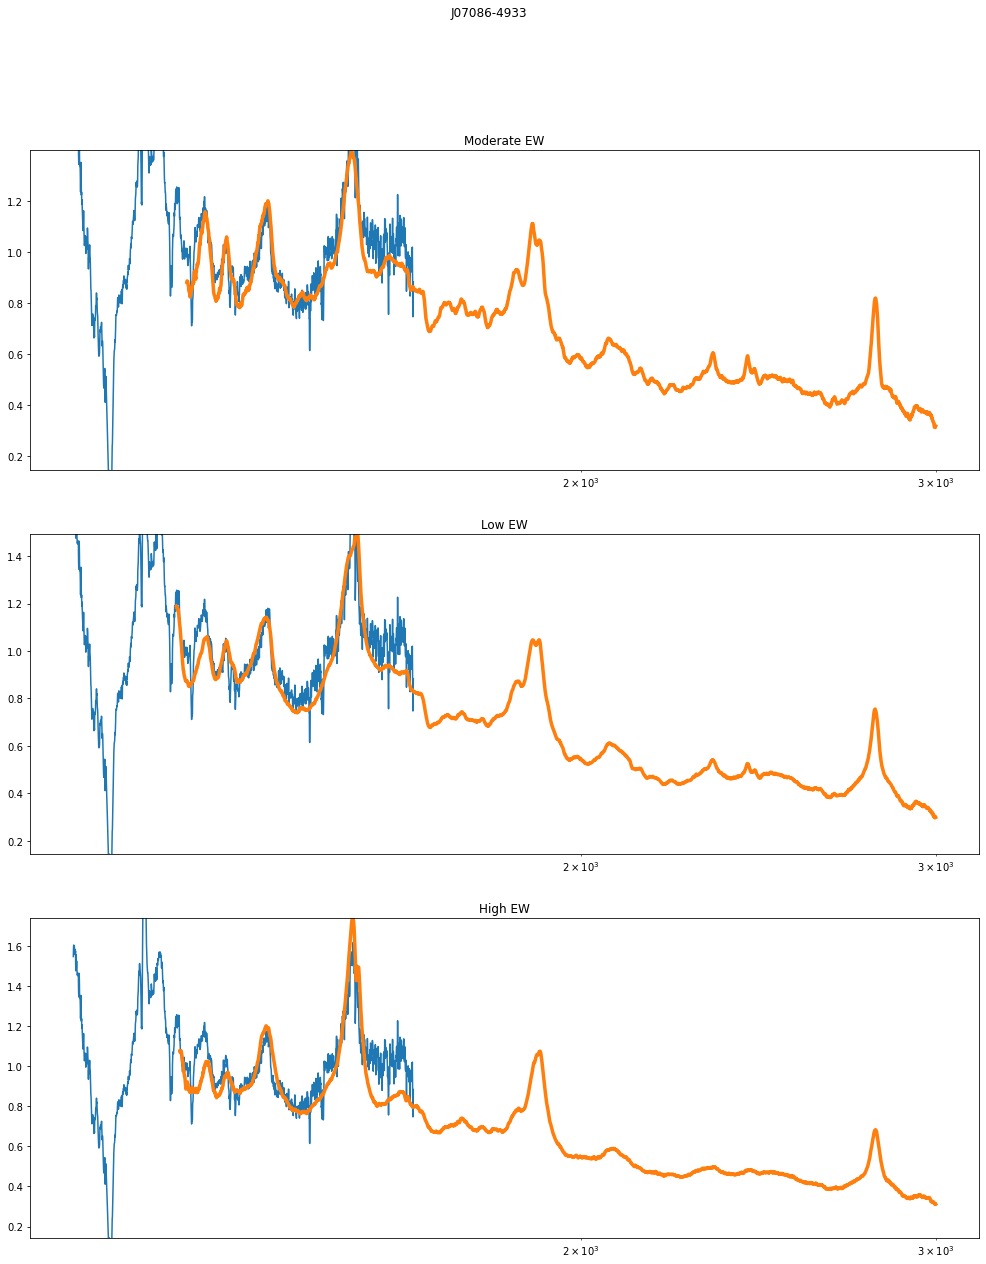

In [8]:
#path = "/Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/"
path = "/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/"
for spec in [x for x in os.listdir(path) if not x.startswith(".")]:
    strlist = spec.split("_")
    if "STIS" in strlist:
        #print("%s%s"%(path,spec))
        #5print(strlist[0])
        spec = fits.open("%s%s"%(path,spec))
        wave = spec[1].data["Wavelength"]
        flux = spec[1].data["Coadded Flux"]
        flux /= np.nanmedian(flux)
        errs = spec[1].data["Flux Errors"] / np.nanmedian(flux)
        mask = spec[1].data["Bad Pixel Mask"]
        do_ICA(wave, flux, errs, mask, strlist[0])
        #plot_spec(wave, flux, errs, mask, strlist[0])